## Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import helper 
from models import *


current_path = os.getcwd()

SEED = 2023

# Define a context manager to temporarily suppress FutureWarnings
class SuppressFutureWarnings:
    def __enter__(self):
        warnings.filterwarnings('ignore', category=FutureWarning)
    
    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('default')

In [3]:
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^TNX"]
start_date = "2010-01-01"
end_date = "2023-01-01"
stock_data = {}
MAs = [5, 10, 20, 50, 100, 200]

for stock in STOCKS: 
    try:
        data_path = os.path.join(current_path, "data", f"{stock}_{start_date}_{end_date}.csv")
        data = pd.read_csv(data_path)
        data['Date'] = pd.to_datetime(data['Date'])
        if stock != "^TNX":
            data['rsi_class'] = helper.compute_rsi_class(data)  # Assuming you have this function in helper
            data['volume_class'] = helper.compute_volume_class(data)  # Add volume analysis
            data = helper.calculate_mas(data, MAs, column_name="Close")
            data['WVAD'] = helper.calculate_wvad(data, period=14)
            data['ROC'] = helper.calculate_roc(data, period=14)
            data['MACD'], data['macd_line'], data['signal_line'] = helper.calculate_macd(data, short_window=12, long_window=26, signal_window=9)
            data['CCI'] =  helper.calculate_cci(data, period=20)
            data['Upper Band'], data['Lower Band'], data['SMA'] = helper.calculate_bollinger_bands(data, window=20, num_std_dev=2)
            data['SMI'] = helper.calculate_smi(data, period=14, signal_period=3)
            data['ATR'] = helper.calculate_atr(data, period=14)
            data[['WVF', 'upperBand', 'rangeHigh', 'WVF_color']] = helper.cm_williams_vix_fix(data['Close'], data['Low'])
            data[['Buy_Signal', 'Sell_Signal', 'BB_Upper', 'BB_Lower']] = helper.bollinger_rsi_strategy(data['Close'])
            data = helper.on_balance_volume(data)
            data = helper.volume_price_trend(data)
            data = helper.money_flow_index(data)
            data = helper.accumulation_distribution(data)
        stock_data[stock] = data
        print(f"Data fetched for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {str(e)}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^TNX


## Model

### XGBoost

In [11]:
fromDate = "2010-01-01"
toDate = '2023-01-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
stock = 'AAPL'
window_size = 200
late = 5
starting_funds = 50000
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, late=late)
    xgboost_stock_predictor.fit_predict()
    xgboost_stock_predictor.print_metrics()
    xgboost_stock_predictor.df.columns

Processing: 100%|██████████| 2866/2866 [02:46<00:00, 17.20it/s]

Mean Squared Error (MSE): 4.568191920142539
Mean Absolute Percentage Error (MAPE): 1.87%
Root Mean Squared Error (RMSE): 2.137332898764846


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


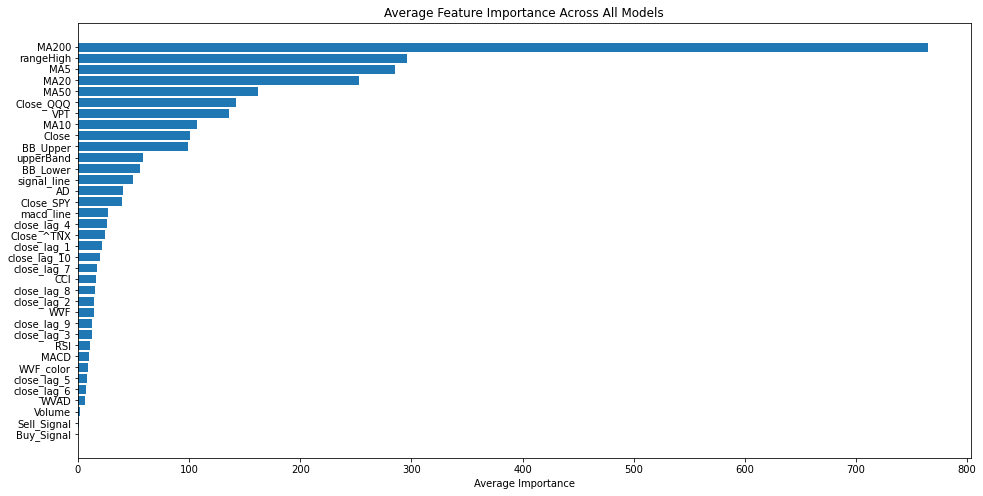

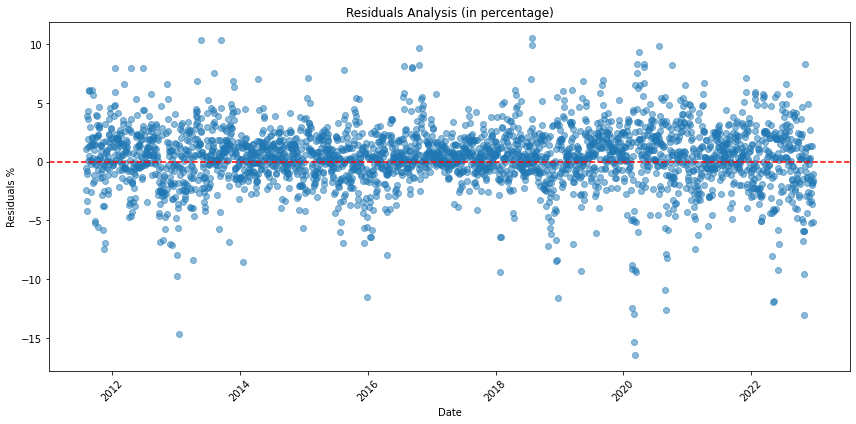

In [12]:
xgboost_stock_predictor.show_feature_importance()
xgboost_stock_predictor.plot_residuals()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


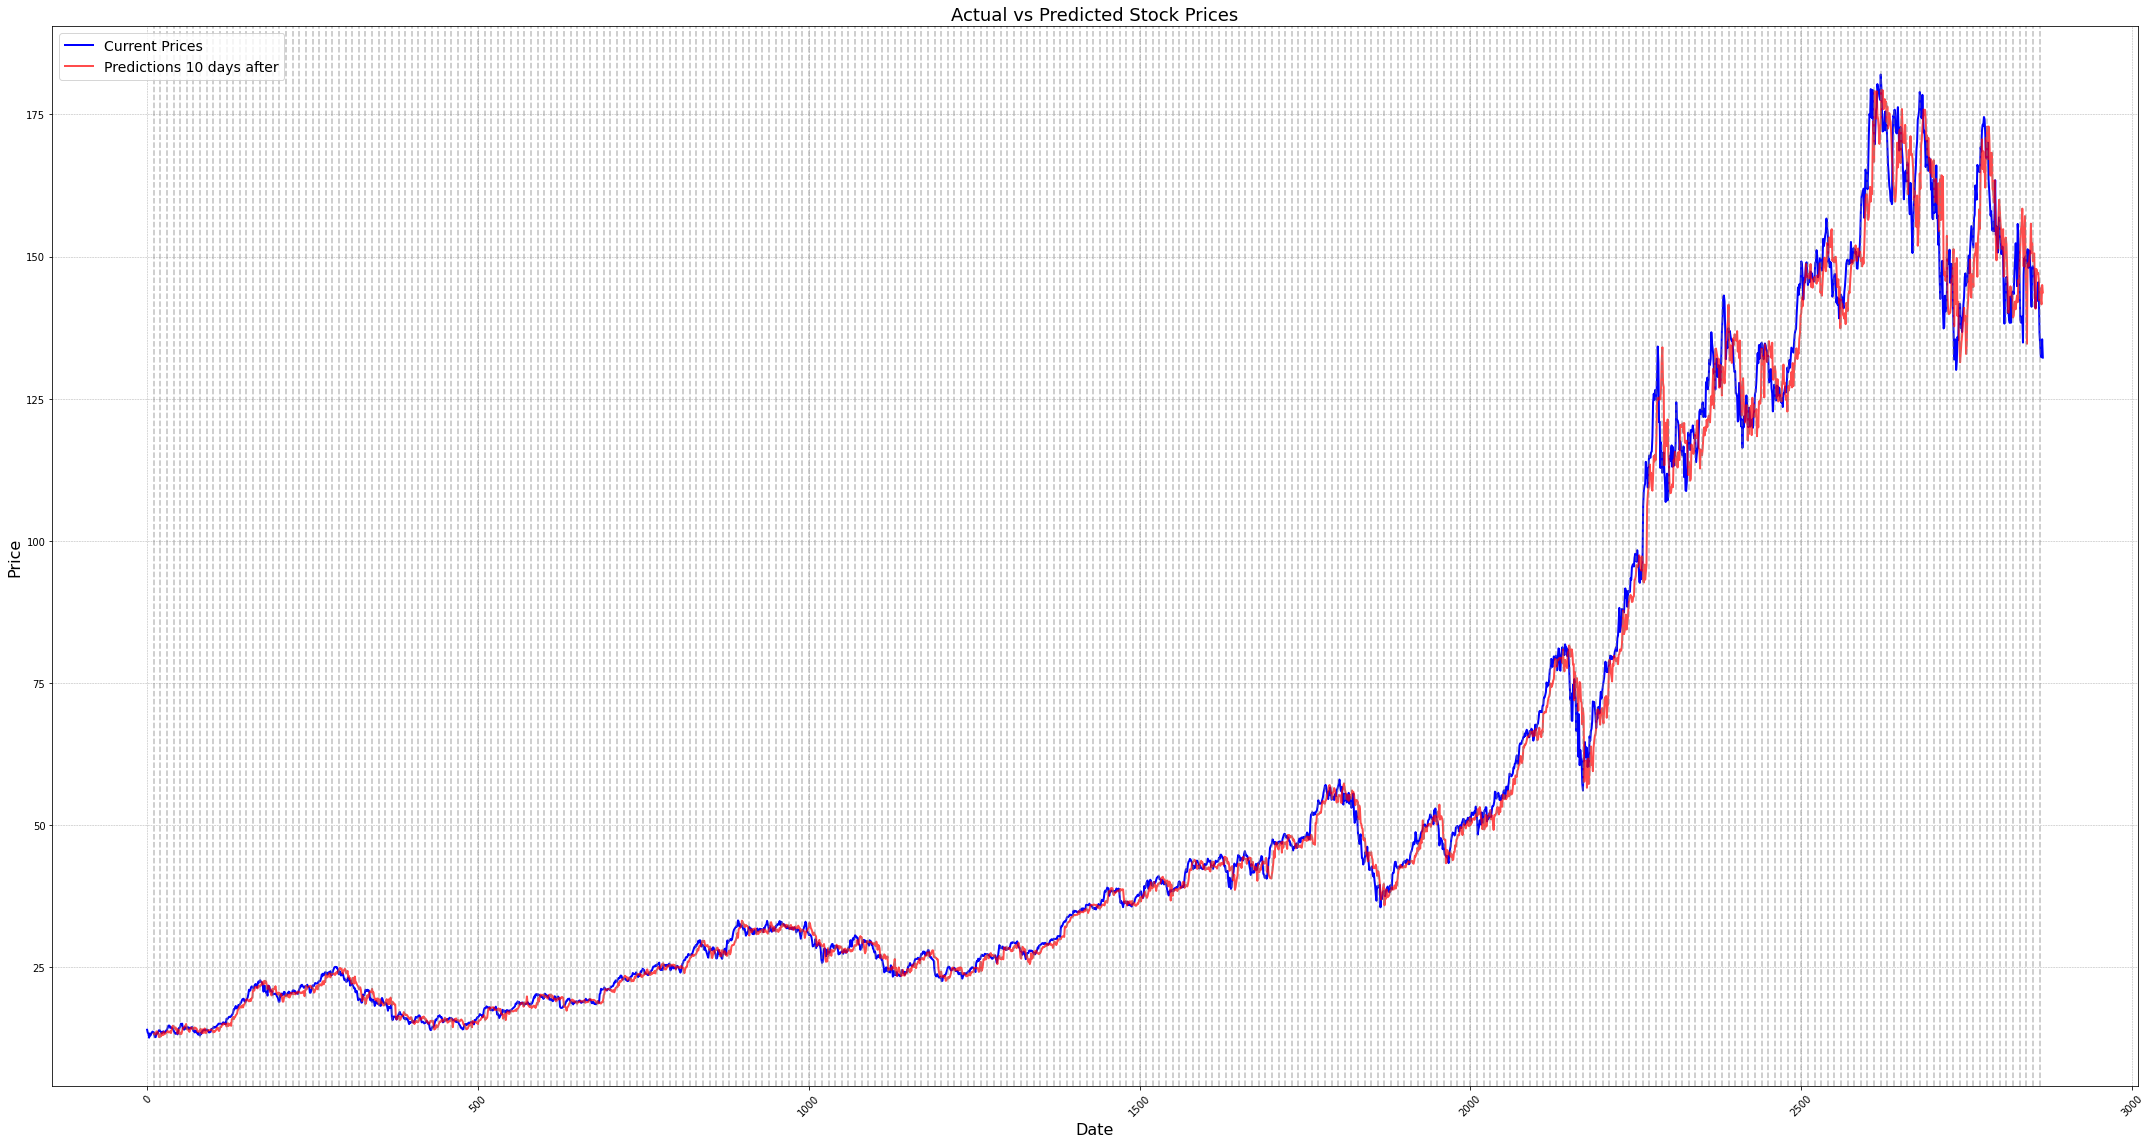

In [15]:
xgboost_stock_predictor.plot_actual_vs_predicted(prediction_lag=10)

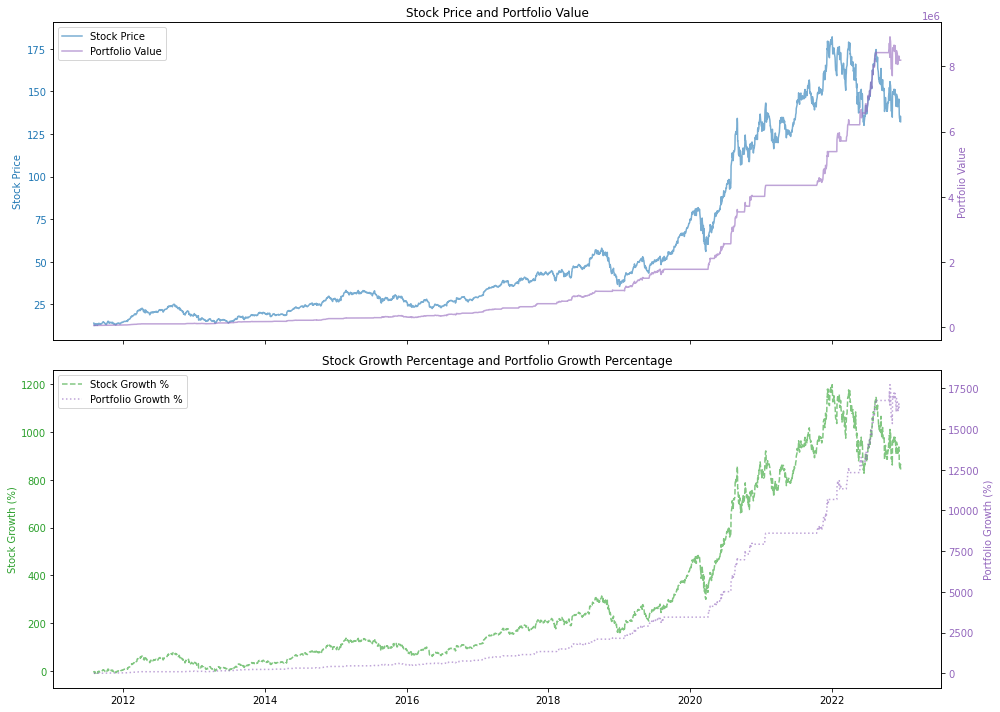

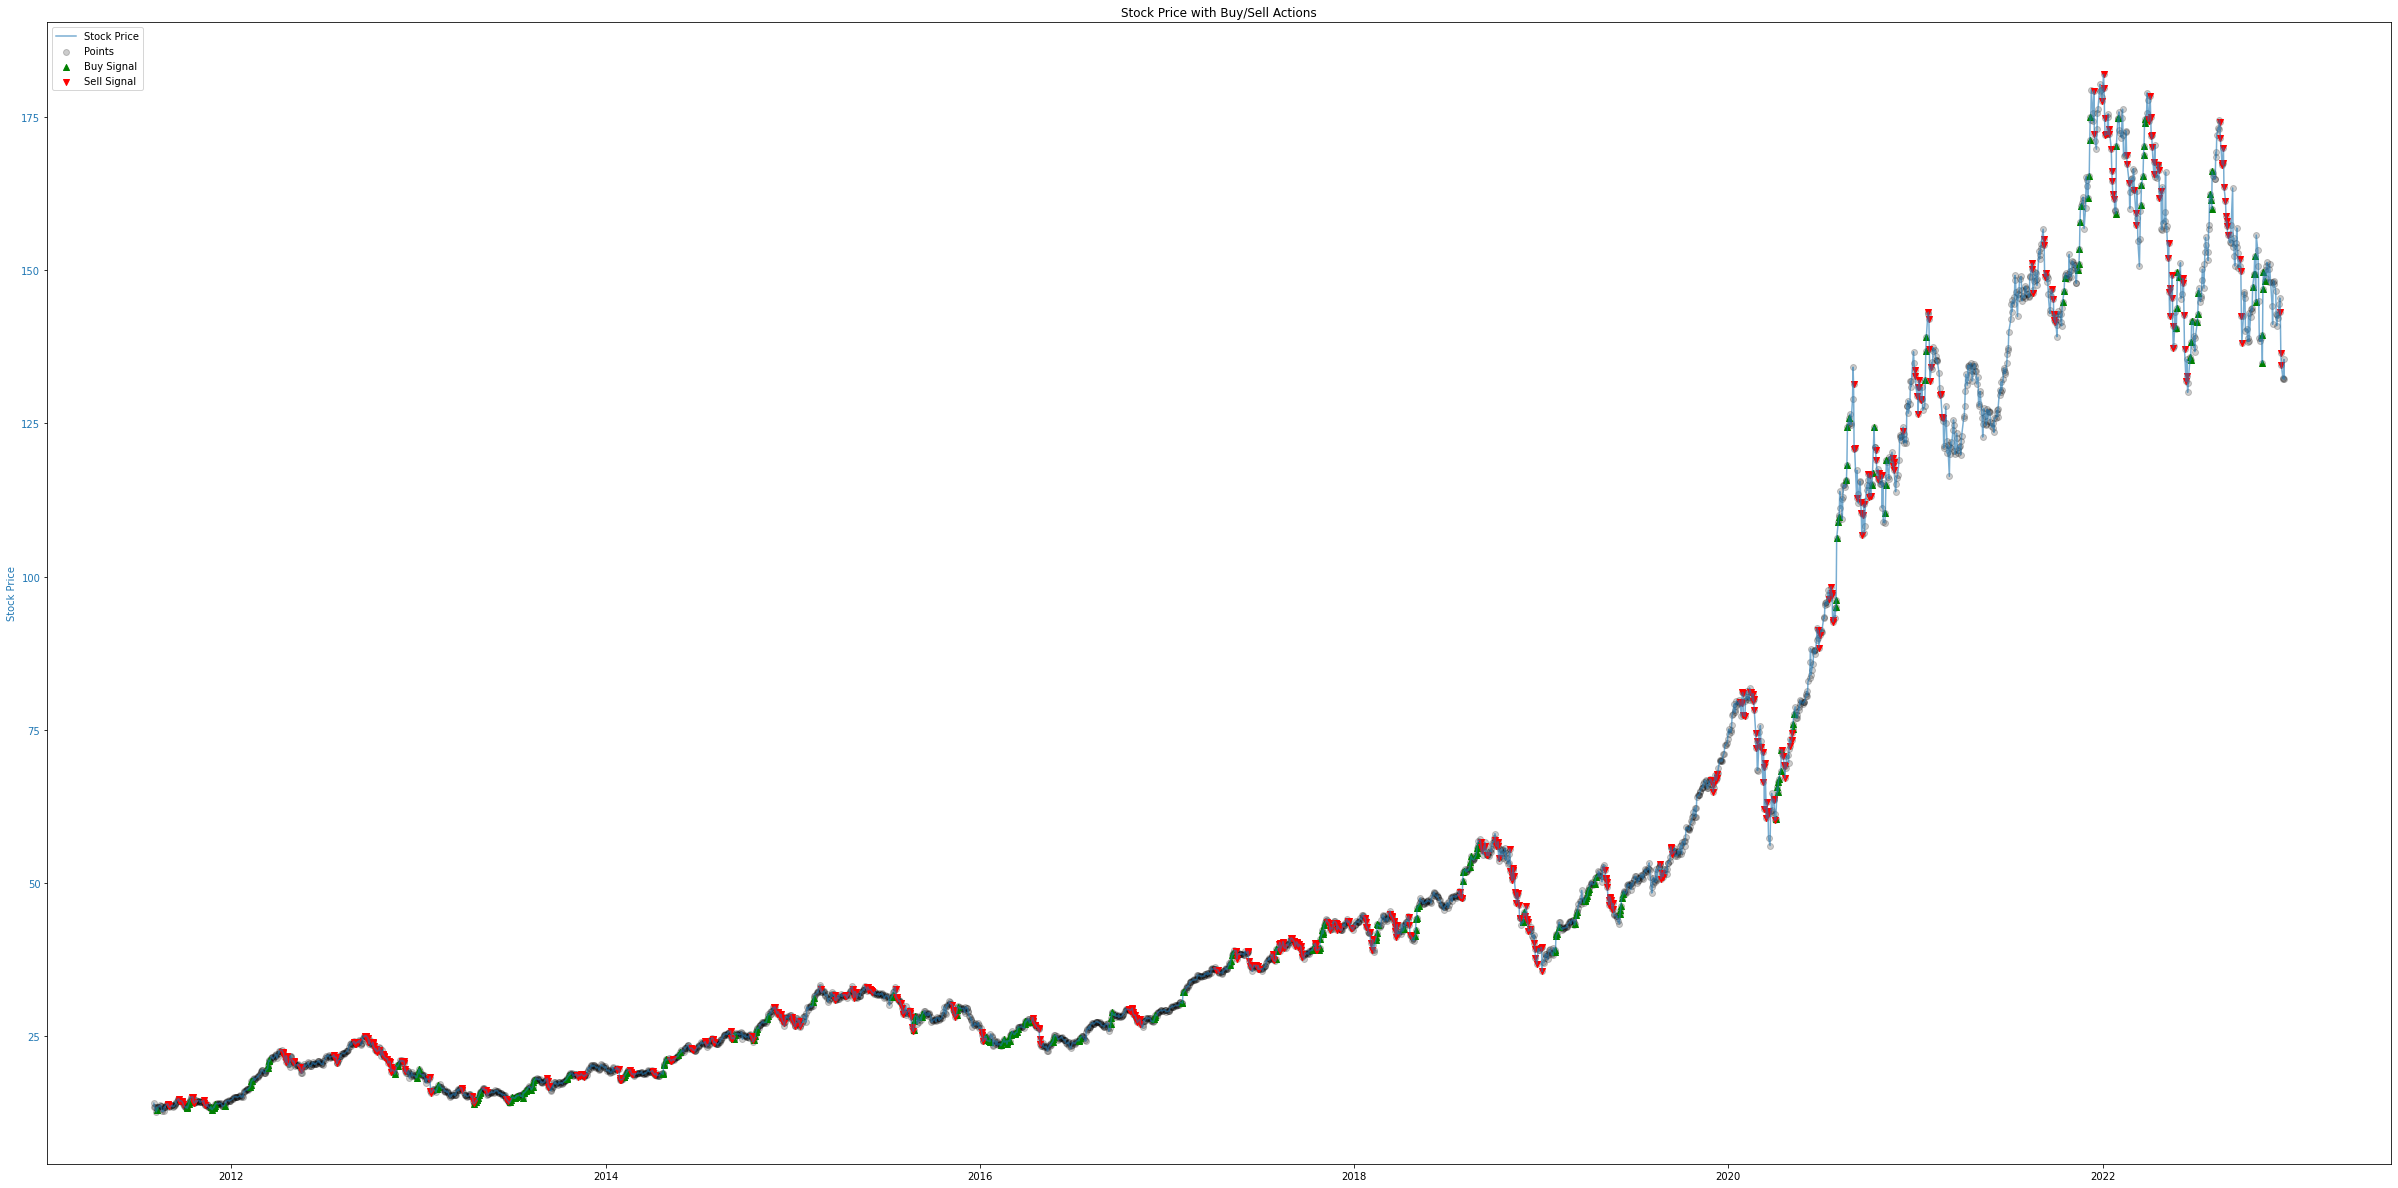

In [16]:
xgboost_stock_predictor.trading_strategy(window_size=window_size, starting_funds=starting_funds)

### LSTM, inspired by A deep learning framework for financial time series using stacked autoencoders and longshort term memory

## other

In [8]:
def determine_trend(df, short_window=50, long_window=200, threshold=0.01):
    """
    Determine the trend based on moving averages.
    
    Parameters:
    - df: DataFrame with the stock data
    - short_window: Window for the short-term SMA
    - long_window: Window for the long-term SMA
    - threshold: Percentage difference between SMAs to consider as 'No trend'
    
    Returns:
    - trend: List with 'Uptrend', 'Downtrend' or 'No trend' for each row in df
    """
    # Calculate short and long moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    # Calculate the trend
    conditions = [
        (df['Short_MA'] > df['Long_MA'] * (1 + threshold)), # Uptrend condition
        (df['Short_MA'] < df['Long_MA'] * (1 - threshold))  # Downtrend condition
    ]
    choices = ['Uptrend', 'Downtrend']
    
    df['Trend'] = np.select(conditions, choices, default='No trend')
    
    return df['Trend'].tolist()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
stock_apple = stock_data['AAPL'].copy()
stock_apple['Trend'] = determine_trend(stock_apple)


In [10]:
def plot_stock_with_trend(df):
    apdict = [mpf.make_addplot(df['Short_MA'], color='blue', linestyle='--'),
              mpf.make_addplot(df['Long_MA'], color='red', linestyle='--')]
    
    mpf.plot(df, type='candle', style='yahoo', volume=True, title='Stock with Trend Indicator',
             ylabel='Price', figratio=(400, 120), mav=(100, 400), addplot=apdict, 
             hlines=dict(hlines=[df['Close'].mean()], colors=['blue'], linewidths=[2]))

plot_stock_with_trend(stock_apple)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Expect data.index as DatetimeIndex

In [ ]:
# Calculate the weekly return
stock_apple['Weekly_Return'] = stock_apple['Close'].resample('W').ffill().pct_change()


# Display statistics
stats = stock_apple['Weekly_Return'].describe()
stats